# Introducción a la Ciencia de Datos: Tarea 1

Este notebook contiene el código de base para realizar la Tarea 1 del curso. Puede copiarlo en su propio repositorio y trabajar sobre el mismo.
Las **instrucciones para ejecutar el notebook** están en la [página inicial del repositorio](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd).

Se utiliza el lenguaje Python y la librería Pandas. Si no tiene ninguna familiaridad con la librería, se recomienda realizar algún tutorial introductorio (ver debajo).
También se espera que los alumnos sean proactivos a la hora de consultar las documentaciones de las librerías y del lenguaje, para entender el código provisto.
Además de los recursos provistos en la [página del curso](https://eva.fing.edu.uy/course/view.php?id=1378&section=1), los siguientes recursos le pueden resultar interesantes:
 - [Pandas getting started](https://pandas.pydata.org/docs/getting_started/index.html#getting-started) y [10 minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html): Son parte de la documentación en la página oficial de Pandas.
 - [Kaggle Learn](https://www.kaggle.com/learn): Incluye tutoriales de Python y Pandas.


Si desea utilizar el lenguaje R y está dispuesto a no utilizar (o traducir) este código de base, también puede hacerlo.

En cualquier caso, **se espera que no sea necesario revisar el código para corregir la tarea**, ya que todos los resultados y análisis relevantes deberían estar en el **informe en formato PDF**.

## Cargar bibliotecas (dependencias)
Recuerde instalar los requerimientos (`requirements.txt`) en el mismo entorno donde está ejecutando este notebook (ver [README](https://github.com/DonBraulio/introCD)).

In [2]:
from time import time
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np

# Parte 1

## Parte A: Cargado y Limpieza de Datos

In [7]:
# 2 ── Load CSV (relative path)
DATA_PATH = Path("..") / "data" / "us_2020_election_speeches.csv"
assert DATA_PATH.exists(), f"CSV not found: {DATA_PATH.resolve()}"

df_speeches = (
    pd.read_csv(
        DATA_PATH,
        parse_dates=["date"],
        dtype={"speaker": "category"}  # optional memory optimisation
    )
)

display(df_speeches.head())
display(df_speeches.info())

,speaker,title,text,date,location,type
0,David Perdue,Georgia Sen. David Perdue Speech Transcript at...,David Perdue: (00:01)\nHow great is it to be b...,2020-10-16,"Macon, Georgia",Campaign Speech
1,Joe Biden,"Joe Biden Southfield, MI Speech on Health Care...","Joe Biden: (00:00)\nHello, Michigan. Hi, how a...",2020-10-16,"Southfield ,Michigan",Campaign Speech
2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,President Trump: (00:30)\nThank you. What a ni...,2020-10-16,"Fort Myers, Florida",Campaign Speech
3,Joe Biden,Joe Biden ABC Town Hall Transcript October 15,"George Stephanopoulos: (00:41)\nHey, and welco...",2020-10-15,ABC,Town Hall
4,Donald Trump,Donald Trump NBC Town Hall Transcript October 15,Savannah Guthrie: (03:50)\nIt’s nothing but no...,2020-10-15,NBC,Town Hall


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   speaker   266 non-null    category      
 1   title     269 non-null    object        
 2   text      269 non-null    object        
 3   date      269 non-null    datetime64[ns]
 4   location  251 non-null    object        
 5   type      248 non-null    object        
dtypes: category(1), datetime64[ns](1), object(4)
memory usage: 13.5+ KB


None

#### Limpieza de Datos

In [19]:
# 3 ── Missing‑value audit  (do NOT mutate yet)
na_report = (
    df_speeches
        .isna()                    # Creates a boolean DataFrame (True where values are missing)
        .sum()                     # Counts missing values for each column
        .rename("missing_count")   # Names this count "missing_count"
        .to_frame()                # Converts the Series to a DataFrame with one column
)
na_report["percentage"] = (na_report["missing_count"].div(len(df_speeches)) * 100).round(1).astype(str) + '%'  # Adds % column (missing/total)

print("Rows total:", len(df_speeches))  # Prints total number of rows in original dataset
display(na_report.sort_values("missing_count", ascending=False))  # Shows columns with most missing values first

# Dropping na rows, we could also only drop rows with missing values in specific columns
# df_speeches_clean = df_speeches.dropna(subset=["speaker", "text"])

df_speeches_clean = df_speeches.dropna()  # Creates new DataFrame without any rows containing NaN
print("Rows after drop:", len(df_speeches_clean))  # Shows how many rows remain after dropping

Rows total: 269


,missing_count,percentage
type,21,7.8%
location,18,6.7%
speaker,3,1.1%
title,0,0.0%
date,0,0.0%
text,0,0.0%


Rows after drop: 237


#### Cinco candidatos con mayor candidad de discursos

In [21]:
# 4 ── Identify top‑5 speakers by # of speeches
top5_counts = (
    df_speeches_clean["speaker"]
        .value_counts()
        .head(5)
)
top5 = top5_counts.index.tolist()

print("Top‑5 speakers by # speeches:")
print(top5_counts.to_string())

Top‑5 speakers by # speeches:
speaker
Joe Biden         60
Donald Trump      51
Mike Pence        19
Bernie Sanders    12
Kamala Harris     11


In [35]:
# 5 ── Subset to the five top speakers
df_speeches_top5 = df_speeches_clean[df_speeches_clean["speaker"].isin(top5)].copy()
print("Subset size:", len(df_speeches_top5))


Subset size: 153


## Parte B: Visualización de Datos

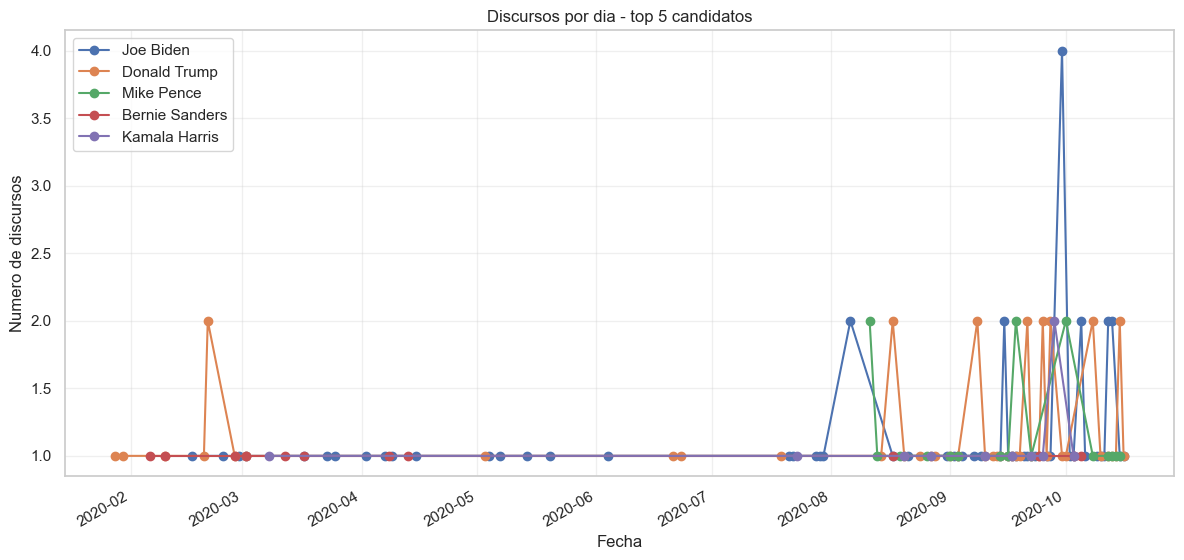

In [37]:
# Plot speeches per day for top-5 speakers
plt.figure(figsize=(12, 6))

# Loop through each speaker and plot their data separately
for speaker in top5:
    # Get data for this speaker
    speaker_data = df_speeches_top5[df_speeches_top5["speaker"] == speaker]

    # Count speeches by date
    date_counts = speaker_data.groupby("date", observed=True).size()

    # Plot this speaker's line
    plt.plot(date_counts.index, date_counts.values, marker="o", label=speaker)

# Add labels and improve appearance
plt.title("Discursos por dia - top 5 candidatos")
plt.ylabel("Numero de discursos")
plt.xlabel("Fecha")
plt.legend()
plt.grid(alpha=0.3)

# Improve date formatting
plt.gcf().autofmt_xdate()
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add some extra space for the title
plt.show()

####  Joe Biden da 4 discuros el 30-09-2020

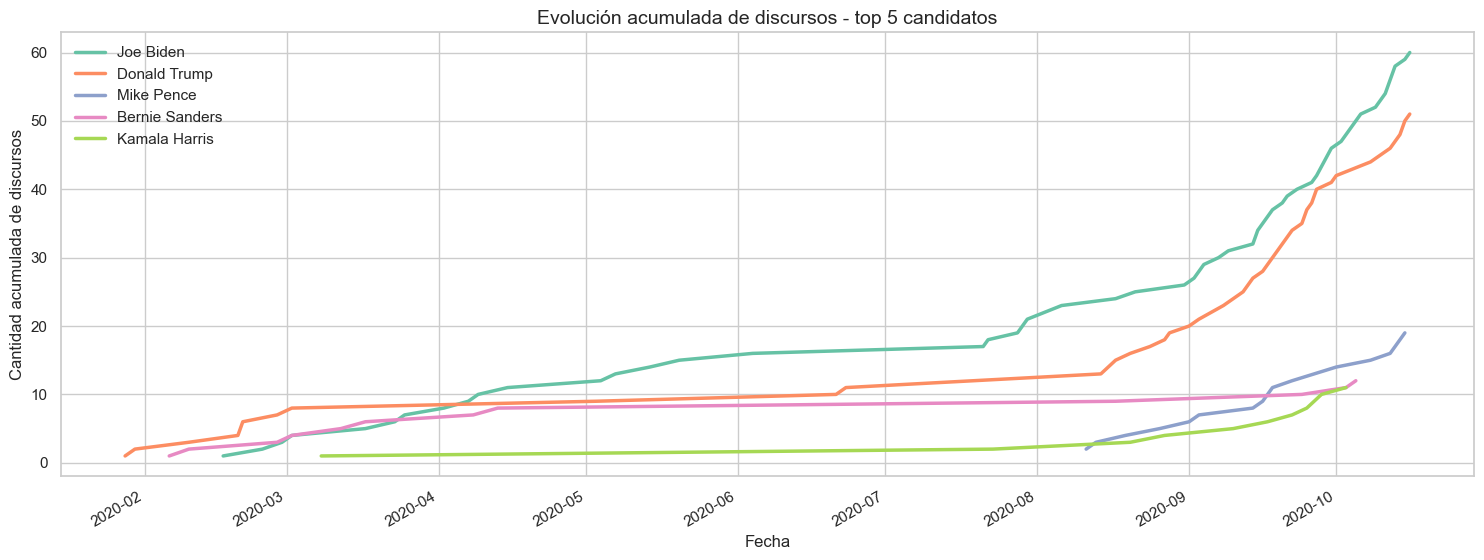

In [39]:
# df_speeches_top5 is already a copy

# --- 2) Date conversion is already done in previous cells ---

# --- 3) Calculate cumulative counts more directly ---
plt.figure(figsize=(15, 6))
sns.set_style("whitegrid")
palette = sns.color_palette("Set2", n_colors=len(top5))

# Process each speaker individually to avoid groupby warnings
for i, speaker in enumerate(top5):
    # Get only this speaker's data
    speaker_data = df_speeches_top5[df_speeches_top5["speaker"] == speaker]

    # Group by date and count speeches
    daily = speaker_data.groupby("date", observed=True).size()

    # Calculate cumulative sum
    cumulative = daily.cumsum()

    # Plot this speaker's line
    plt.plot(
        cumulative.index,
        cumulative.values,
        label=speaker,
        linewidth=2.5,
        color=palette[i]
    )

# Formatting and labels
plt.title("Evolución acumulada de discursos - top 5 candidatos", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Cantidad acumulada de discursos")
plt.legend(frameon=False)

# Improve date formatting
plt.gcf().autofmt_xdate()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Primer discurso de cada candidato


In [41]:
# Get the first speech date for each candidate
first_speeches = df_speeches_top5.groupby("speaker", observed=True)["date"].min().sort_values()

# Create a more informative display
print("First speech date by each candidate:\n")
for speaker, first_date in first_speeches.items():
    # Format date nicely
    formatted_date = first_date.strftime("%B %d, %Y")

    # Highlight Mike Pence starting late
    if speaker == "Mike Pence":
        print(f"{speaker}: {formatted_date} 📅 <- Started later than other candidates")
    else:
        print(f"{speaker}: {formatted_date}")

# Calculate days since first speech in dataset
earliest_date = first_speeches.min()
print("\nDays since earliest speech:")
for speaker, first_date in first_speeches.items():
    days_delay = (first_date - earliest_date).days
    print(f"{speaker}: {days_delay} days after first campaign speech")

First speech date by each candidate:

Donald Trump: January 28, 2020
Bernie Sanders: February 06, 2020
Joe Biden: February 17, 2020
Kamala Harris: March 08, 2020
Mike Pence: August 11, 2020 📅 <- Started later than other candidates

Days since earliest speech:
Donald Trump: 0 days after first campaign speech
Bernie Sanders: 9 days after first campaign speech
Joe Biden: 20 days after first campaign speech
Kamala Harris: 40 days after first campaign speech
Mike Pence: 196 days after first campaign speech


## Parte C: Conteo de Palabras

In [51]:
import re, string

def clean_text(text_series: pd.Series) -> pd.Series:
    """
    Clean political speech text for word frequency analysis.

    Performs the following transformations:
    1. Converts text to lowercase
    2. Removes introductory content (before first newline)
    3. Removes URLs and bracketed content
    4. Removes punctuation and special characters
    5. Normalizes whitespace
    6. Removes numbers and digit-based text

    Parameters:
    -----------
    text_series : pd.Series
        Series containing text to be cleaned

    Returns:
    --------
    pd.Series : Cleaned text series
    """
    # Make a copy to avoid modifying the original
    txt = text_series.copy()

    # 1. Convert to lowercase (standardize case)
    txt = txt.str.lower()

    # 2. Remove everything before first newline (often speaker intro)
    txt = txt.str.replace(r"^[^\n]*\n", " ", regex=True)

    # 3. Remove URLs and social media handles
    txt = txt.str.replace(r"http\S+|www\.\S+", " ", regex=True)
    txt = txt.str.replace(r"@\S+", " ", regex=True)     # handles

    # 4. Remove bracketed content (citations, stage directions)
    txt = txt.str.replace(r"\[[^\]]*\]", " ", regex=True)
    txt = txt.str.replace(r"\([^)]*\)", " ", regex=True)  # parentheses too

    # 5. Remove numbers (typically not meaningful for word analysis)
    txt = txt.str.replace(r"\b\d+\b", " ", regex=True)

    # 6. Replace punctuation with spaces (expanded character set)
    # Include standard punctuation, typographic marks, and special characters
    punc = string.punctuation + "¡¿""''—–…·""„‚»«›‹"
    txt = txt.str.translate(str.maketrans({c:" " for c in punc}))

    # 7. Collapse multiple whitespace characters
    txt = txt.str.replace(r"\s+", " ", regex=True).str.strip()

    return txt

# Apply the enhanced cleaning function
df_speeches_top5["CleanText"] = clean_text(df_speeches_top5["text"])

# Generate word lists from cleaned text
df_speeches_top5["WordList"] = df_speeches_top5["CleanText"].str.split()

# Display a sample to verify the cleaning process
display(df_speeches_top5[["CleanText", "WordList"]].head(5))

,CleanText,WordList
1,hello michigan hi how are you what’s your name...,"[hello, michigan, hi, how, are, you, what’s, y..."
2,thank you what a nice group thank you very muc...,"[thank, you, what, a, nice, group, thank, you,..."
3,hey and welcome to our town hall with joe bide...,"[hey, and, welcome, to, our, town, hall, with,..."
4,it’s nothing but noise what okay all right lad...,"[it’s, nothing, but, noise, what, okay, all, r..."
5,thank you very much thank you let’s see it’s t...,"[thank, you, very, much, thank, you, let’s, se..."


# Parte 2

## Parte A: Conteo de Palabras y visualización

,Joe Biden,Donald Trump,Mike Pence,Bernie Sanders,Kamala Harris
a,6315,11209,1554,669,954
on,1942,2371,669,235,342
years,370,1651,691,46,46
it,3077,7912,613,222,491
more,923,1294,868,96,83
have,2737,5266,487,323,519
biden,2628,950,385,82,95
that,4944,7470,1572,886,1269
mike,11,237,829,0,0
donald,192,4188,318,43,52


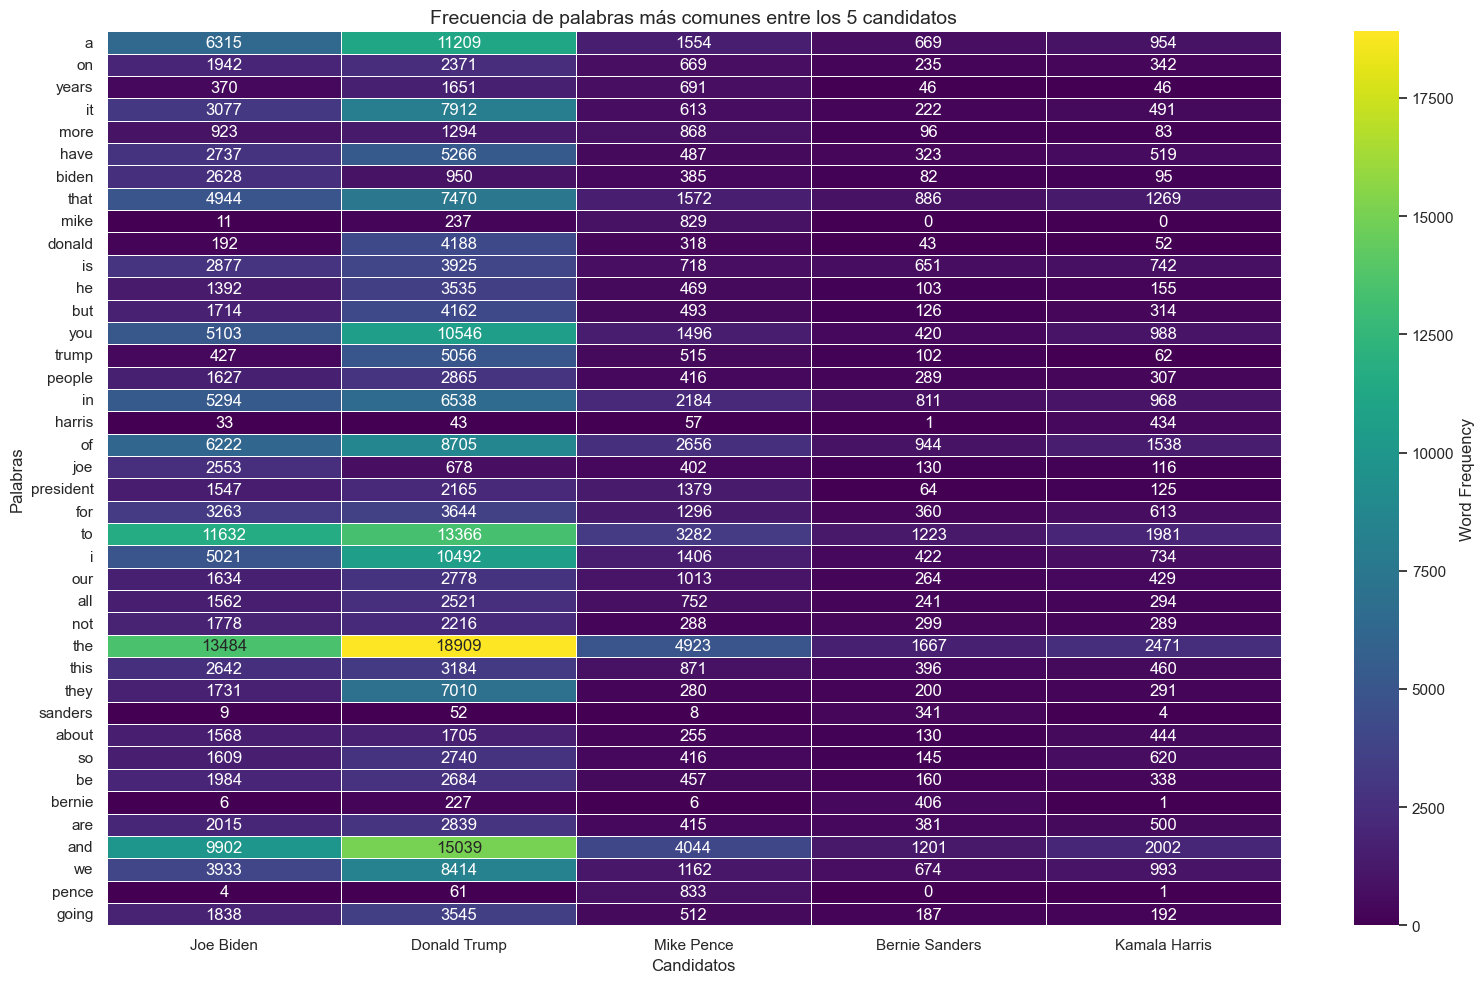

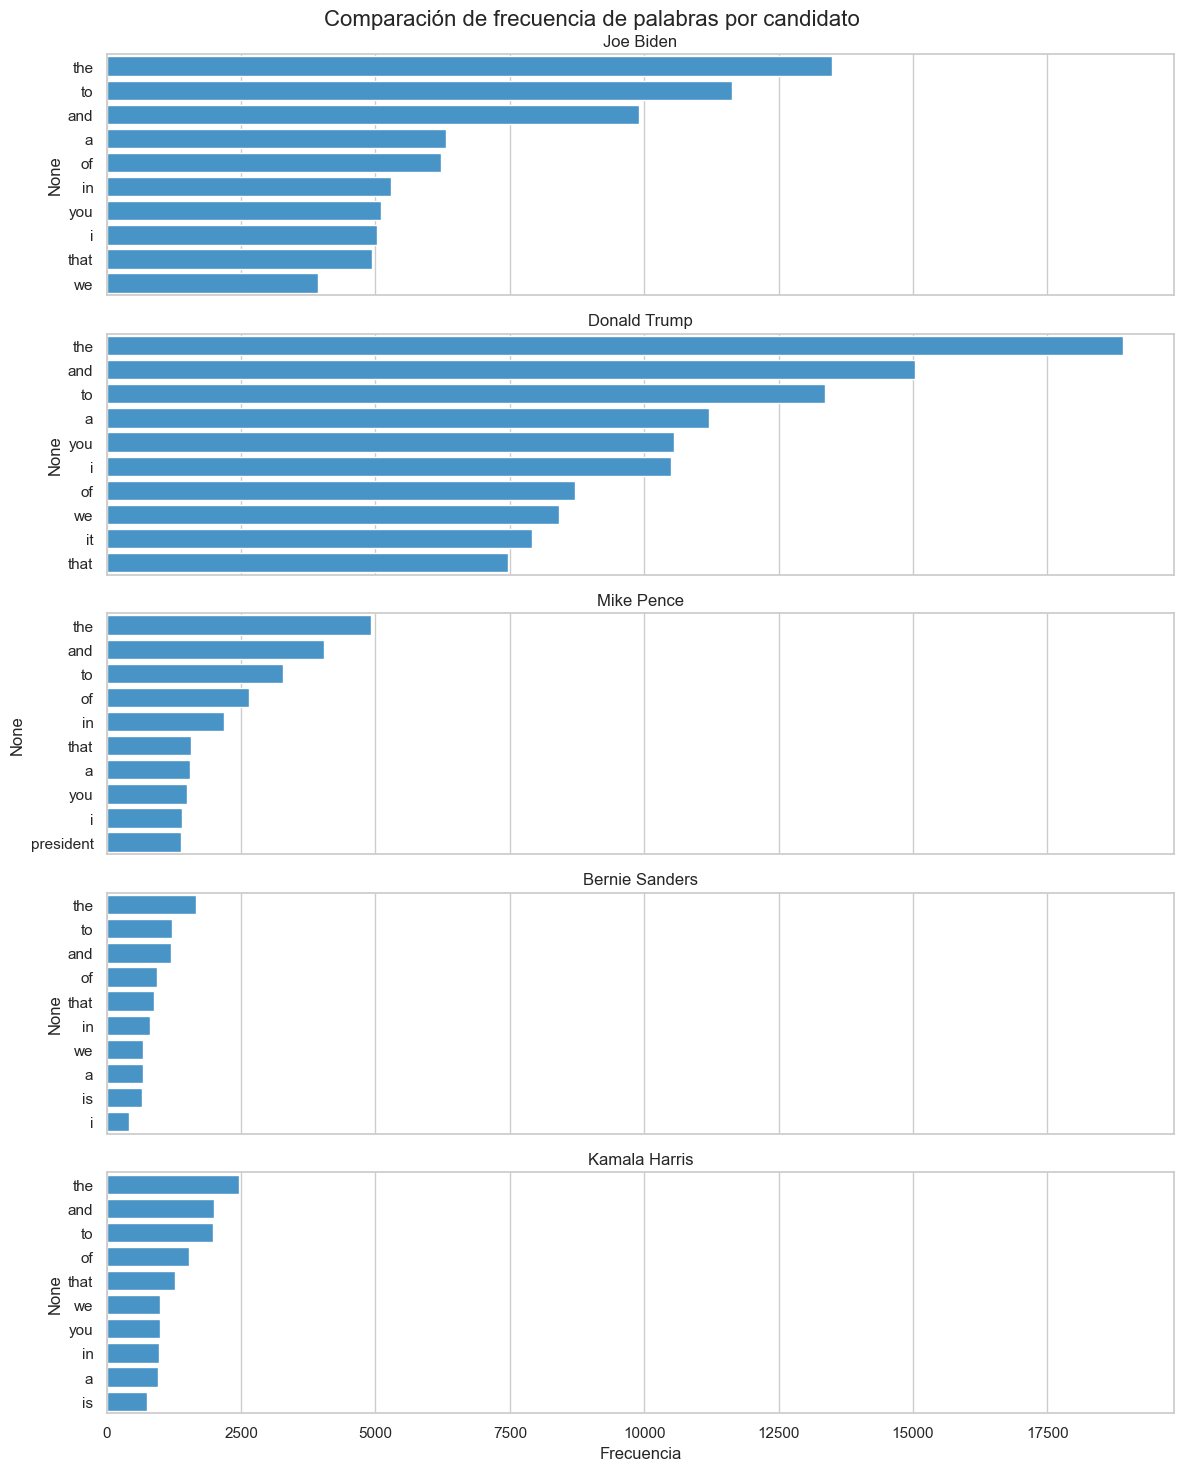

In [55]:
# Visualizing most frequent words for each of the top-5 candidates
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract top words for each speaker
def top_words(df, speaker, n=20):
    """Extract the n most common words used by a specific speaker"""
    # Get all words from this speaker and flatten the list
    tokens = df[df["speaker"] == speaker]["WordList"].explode()
    # Count and return the top n words
    return Counter(tokens).most_common(n)

# Get top words for each candidate
top_words_by_candidate = {sp: dict(top_words(df_speeches_top5, sp)) for sp in top5}

# Get a list of all unique words that appear in any candidate's top list
all_top_words = set()
for word_dict in top_words_by_candidate.values():
    all_top_words.update(word_dict.keys())

# Create a complete DataFrame with all words and their actual frequencies
# This ensures we have the real counts, not zeros
complete_word_counts = {}
for speaker in top5:
    # Get all words from this speaker
    all_tokens = df_speeches_top5[df_speeches_top5["speaker"] == speaker]["WordList"].explode()
    # Count all tokens (not just top N)
    word_counts = Counter(all_tokens)
    # Create dictionary with all top words across candidates
    complete_word_counts[speaker] = {word: word_counts.get(word, 0) for word in all_top_words}

# Create DataFrame from complete counts
top_words_df = pd.DataFrame(complete_word_counts).fillna(0).astype(int)

# Show the DataFrame with top words (for verification)
display(top_words_df.head(10))

# Create a more readable visualization
plt.figure(figsize=(16, 10))
sns.heatmap(
    top_words_df,
    cmap="viridis",
    annot=True,          # Show values in cells
    fmt="d",             # Display as integers
    linewidths=0.5,      # Add grid lines
    cbar_kws={"label": "Word Frequency"}
)
plt.title("Frecuencia de palabras más comunes entre los 5 candidatos", fontsize=14)
plt.ylabel("Palabras")
plt.xlabel("Candidatos")
plt.tight_layout()
plt.show()

# Create a bar chart comparison of top 10 words for each candidate
fig, axes = plt.subplots(len(top5), 1, figsize=(12, 15), sharex=True)
fig.suptitle("Comparación de frecuencia de palabras por candidato", fontsize=16)

for i, speaker in enumerate(top5):
    # Get speaker data and sort by frequency
    speaker_data = top_words_df.loc[:, speaker].sort_values(ascending=False)[:10]

    # Plot horizontal bar chart using updated syntax
    sns.barplot(
        x=speaker_data.values,
        y=speaker_data.index,
        ax=axes[i],
        color="#3498db",
    )
    axes[i].set_title(f"{speaker}")
    axes[i].set_xlabel("Frecuencia")

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

`Sin necesidad de implementarlo, proponga ideas para modificar esta visualización
con el fin de encontrar diferencias entre partidos políticos, fechas, o lugares`


Diferencias entre partidos políticos:

- Agrupar candidatos por afiliación política (Demócratas vs Republicanos) y calcular la frecuencia de palabras agregada para cada partido
- Crear una visualización de "diferencia de frecuencias" donde el tamaño de la palabra indique cuánto más la usa un partido que otro
- Implementar análisis de sentimiento para identificar si ciertos temas son abordados con tonos más positivos o negativos según el partido
- Crear nubes de palabras con códigos de color por partido para identificar visualmente los términos más asociados a cada ideología

Análisis temporal (fechas):

- Dividir el período de campaña en fases (primarias, convenciones, debates, semanas finales) y comparar la evolución del vocabulario
- Crear gráficos de líneas para palabras clave que muestren cómo cambia su frecuencia a lo largo del tiempo
- Implementar análisis de "trending words" para detectar términos que aparecen súbitamente en respuesta a eventos de campaña
- Visualizar la evolución del discurso de cada candidato para identificar cambios estratégicos en sus mensajes

Análisis geográfico (lugares):

- Filtrar discursos por estado o región y comparar las palabras más frecuentes según la ubicación
- Crear mapas de calor geográficos donde el color refleje la frecuencia de términos específicos en cada estado
- Comparar el vocabulario utilizado en estados disputados ("swing states") versus estados tradicionalmente leales a un partido
- Analizar si los candidatos adaptan su mensaje según el contexto regional, económico o demográfico de cada lugar

## Parte B: Problemas al visualizar el conteo de palabras

Un problema importante en el análisis de frecuencia de palabras es que las palabras más comunes suelen ser conectores, artículos y preposiciones (como "the", "and", "to", "of", etc.) que no aportan información relevante sobre el contenido temático de los discursos. Estas "stopwords" o palabras vacías dominan las visualizaciones e impiden ver términos más significativos desde el punto de vista político.

Como se puede observar en los gráficos, las palabras más frecuentes son casi idénticas entre los candidatos y corresponden principalmente a palabras funcionales del idioma. Esto dificulta detectar las diferencias reales en el contenido político de cada discurso y oculta términos relevantes como nombres de oponentes, temas de campaña o propuestas políticas específicas.

En una etapa posterior del análisis, sería conveniente filtrar estas palabras vacías para permitir que emerjan patrones temáticos más significativos, pero por ahora nos centramos en asegurar que los conteos de frecuencia sean correctos para todas las palabras.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bruno\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


,Joe Biden,Donald Trump,Mike Pence,Bernie Sanders,Kamala Harris
”,662,3310,192,48,74
like,778,1873,192,36,127
said,738,2770,273,39,74
know,975,2460,329,93,242
they’re,649,1703,48,39,50
thank,835,1399,269,66,274
us,723,870,210,110,233
want,538,1997,185,92,145
years,370,1651,691,46,46
make,834,608,152,104,111


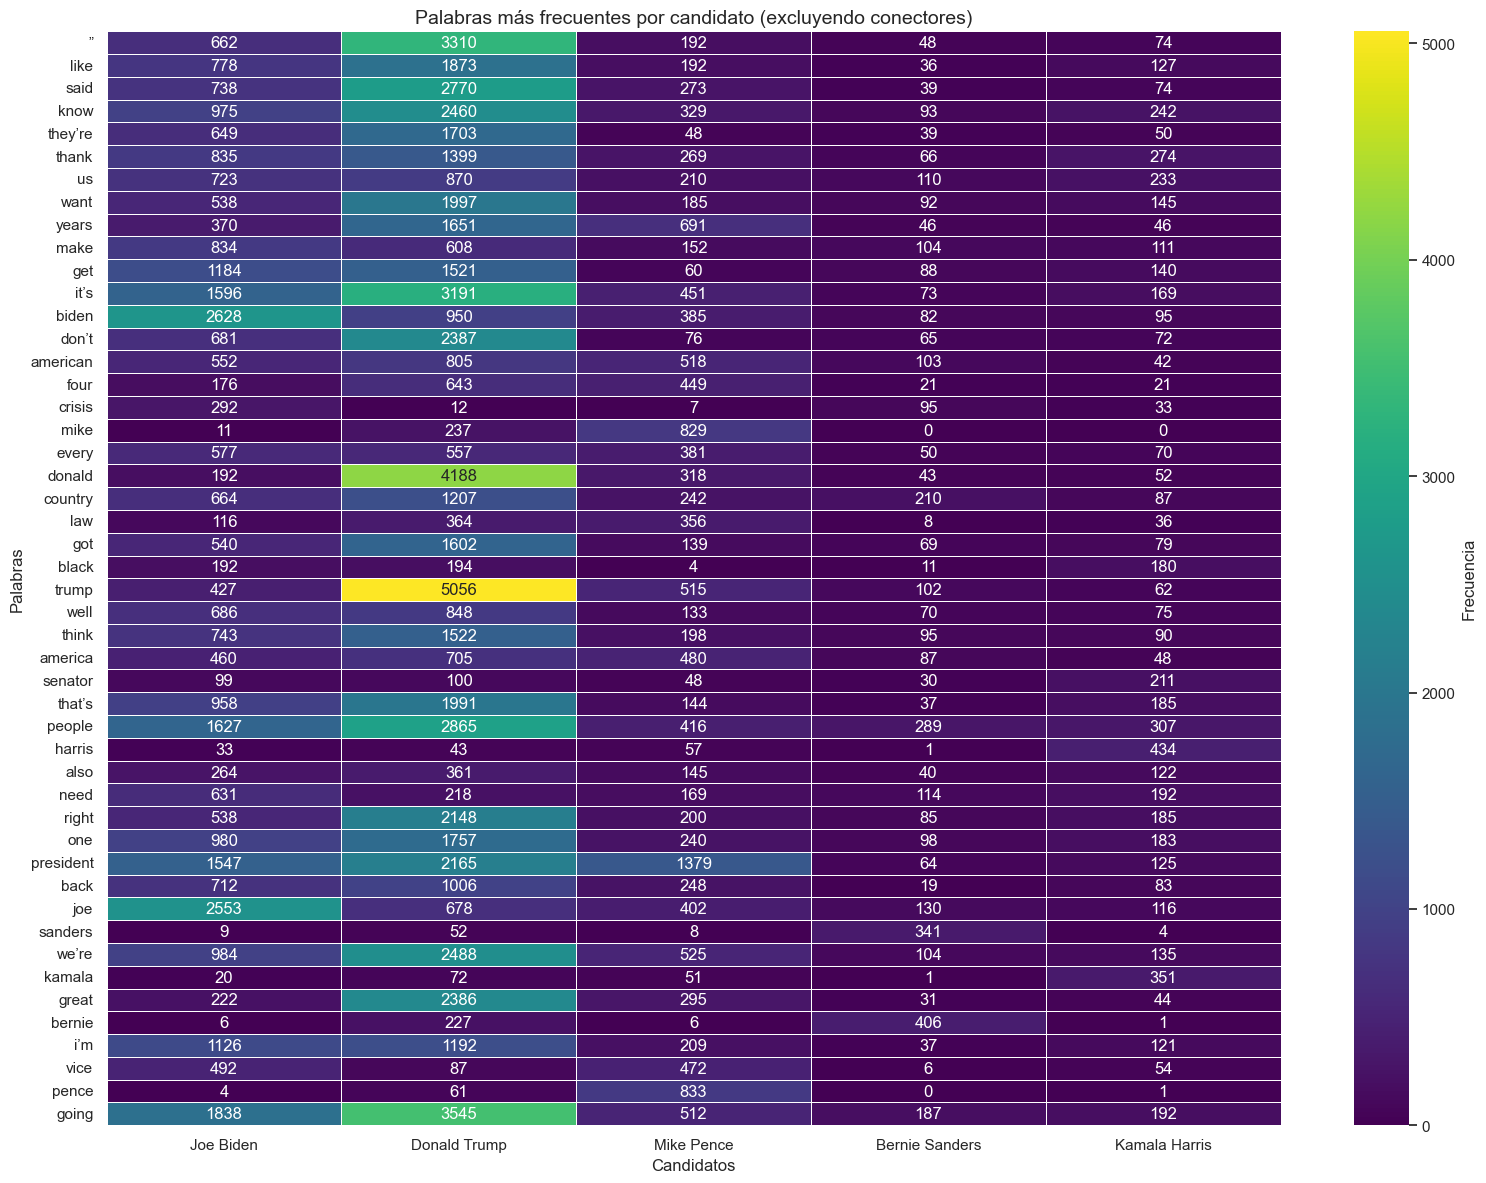

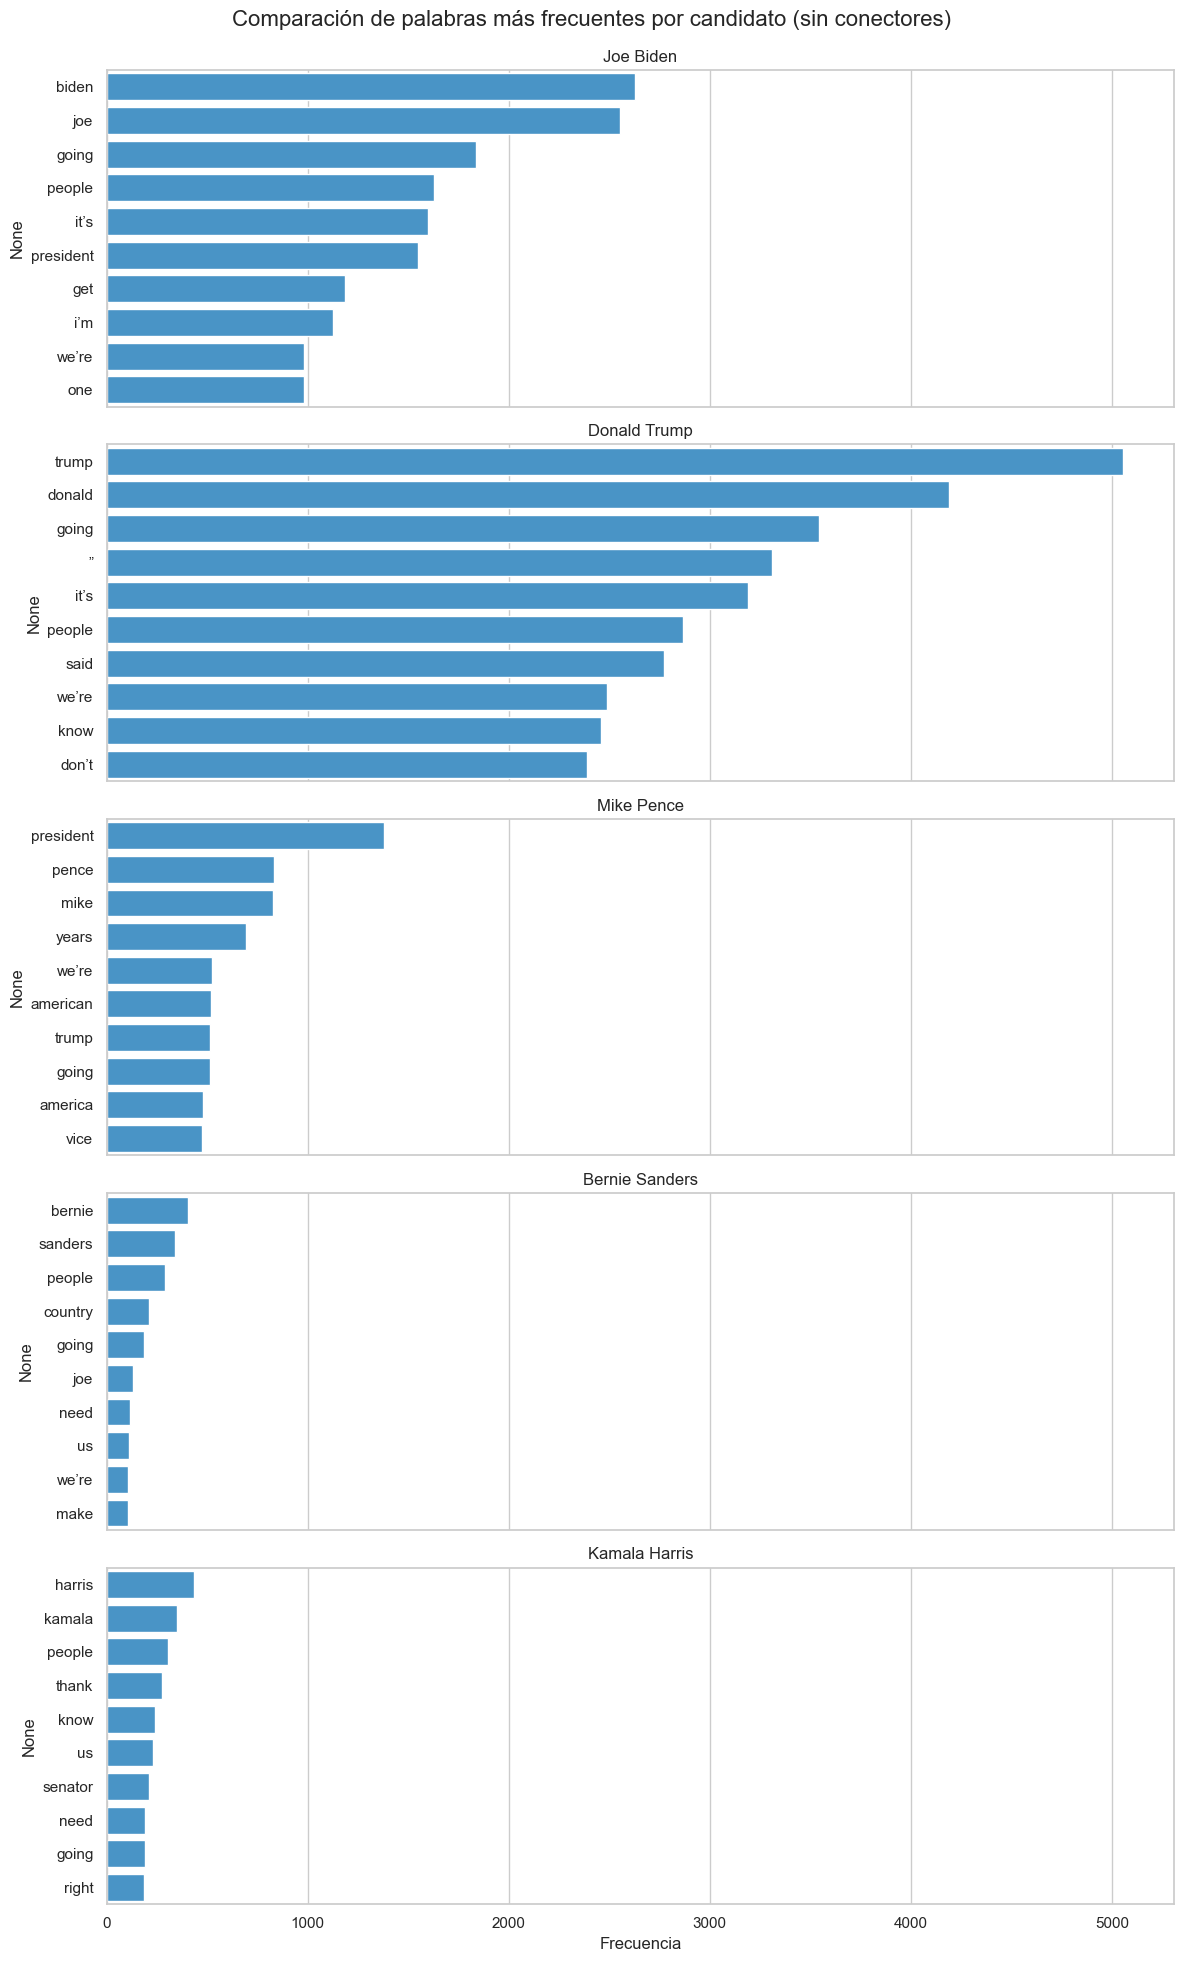

In [56]:
# Visualización de palabras más frecuentes excluyendo conectores (stopwords)
import nltk
from nltk.corpus import stopwords

# Descargar stopwords de NLTK si no están disponibles
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Función para extraer palabras frecuentes excluyendo stopwords
def top_words_no_stopwords(df, speaker, n=20):
    """Extrae las palabras más comunes usadas por un orador, excluyendo stopwords"""
    # Obtener stopwords en inglés
    stop_words = set(stopwords.words('english'))

    # Obtener todas las palabras de este orador
    tokens = df[df["speaker"] == speaker]["WordList"].explode()

    # Filtrar stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Contar y devolver las n palabras más comunes
    return Counter(filtered_tokens).most_common(n)

# Obtener palabras frecuentes sin stopwords para cada candidato
top_words_filtered = {sp: dict(top_words_no_stopwords(df_speeches_top5, sp)) for sp in top5}

# Obtener todas las palabras únicas que aparecen en las listas de cualquier candidato
all_top_filtered_words = set()
for word_dict in top_words_filtered.values():
    all_top_filtered_words.update(word_dict.keys())

# Crear un DataFrame completo con frecuencias reales
filtered_word_counts = {}
for speaker in top5:
    # Obtener todas las palabras del orador
    all_tokens = df_speeches_top5[df_speeches_top5["speaker"] == speaker]["WordList"].explode()
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in all_tokens if word not in stop_words]

    # Contar todas las palabras filtradas
    word_counts = Counter(filtered_tokens)

    # Crear diccionario con todas las palabras top de todos los candidatos
    filtered_word_counts[speaker] = {word: word_counts.get(word, 0) for word in all_top_filtered_words}

# Crear DataFrame desde los conteos completos
filtered_words_df = pd.DataFrame(filtered_word_counts).fillna(0).astype(int)

# Mostrar el DataFrame para verificación
display(filtered_words_df.head(15))

# Crear visualización mejorada de heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(
    filtered_words_df,
    cmap="viridis",
    annot=True,
    fmt="d",
    linewidths=0.5,
    cbar_kws={"label": "Frecuencia"}
)
plt.title("Palabras más frecuentes por candidato (excluyendo conectores)", fontsize=14)
plt.ylabel("Palabras")
plt.xlabel("Candidatos")
plt.tight_layout()
plt.show()

# Crear gráfico de barras para comparar las 10 palabras más frecuentes de cada candidato
fig, axes = plt.subplots(len(top5), 1, figsize=(12, 20), sharex=True)
fig.suptitle("Comparación de palabras más frecuentes por candidato (sin conectores)", fontsize=16)

for i, speaker in enumerate(top5):
    # Obtener datos del orador y ordenar por frecuencia
    speaker_data = filtered_words_df.loc[:, speaker].sort_values(ascending=False)[:10]

    # Crear gráfico de barras horizontal
    sns.barplot(
        x=speaker_data.values,
        y=speaker_data.index,
        ax=axes[i],
        color="#3498db",
    )
    axes[i].set_title(f"{speaker}")
    axes[i].set_xlabel("Frecuencia")

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [61]:
df_speeches["CleanText"] = clean_text(df_speeches["text"])
df_speeches["word_count"] = df_speeches["CleanText"].str.split().str.len()

word_counts = (
    df_speeches.groupby("speaker")["word_count"].sum()
               .sort_values(ascending=False)
)
word_counts.head(10)

C:\Users\bruno\AppData\Local\Temp\ipykernel_18384\1808738730.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_speeches.groupby("speaker")["word_count"].sum()


speaker
Donald Trump                      516264
Joe Biden                         366186
Democratic Candidates             112215
Multiple Speakers                 105538
Mike Pence                        100150
Kamala Harris                      55999
Bernie Sanders                     45786
Lindsey Graham, Jaime Harrison     21408
Donald Trump, Joe Biden            20983
Joe Biden, Bernie Sanders          19328
Name: word_count, dtype: int64

## Parte C: Matriz de Menciones

Calculando menciones entre candidatos...


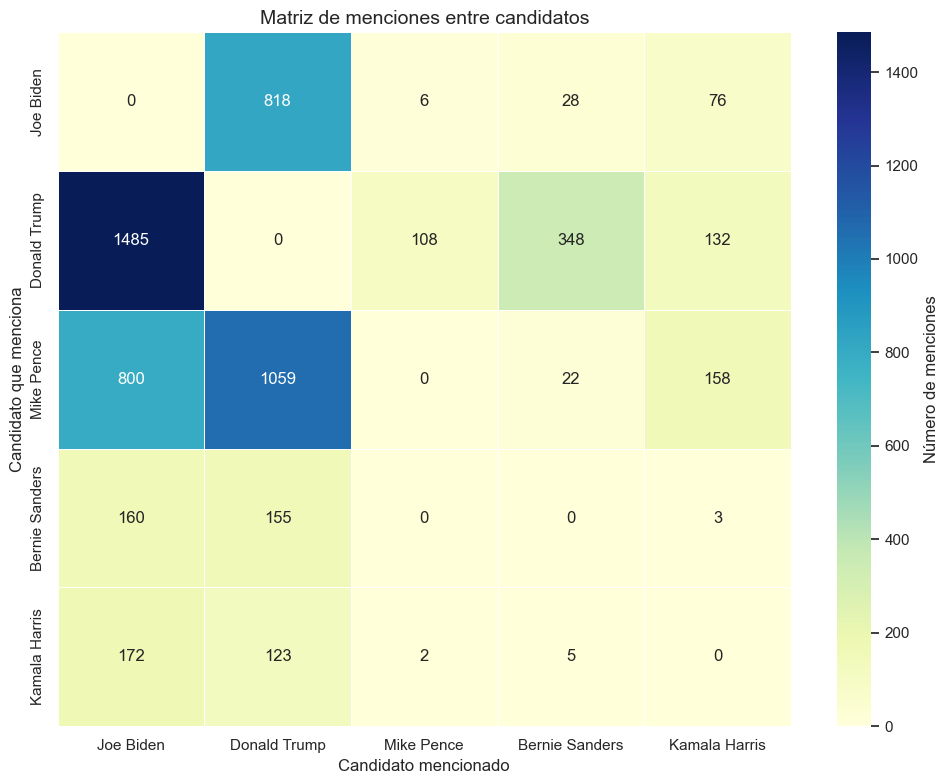

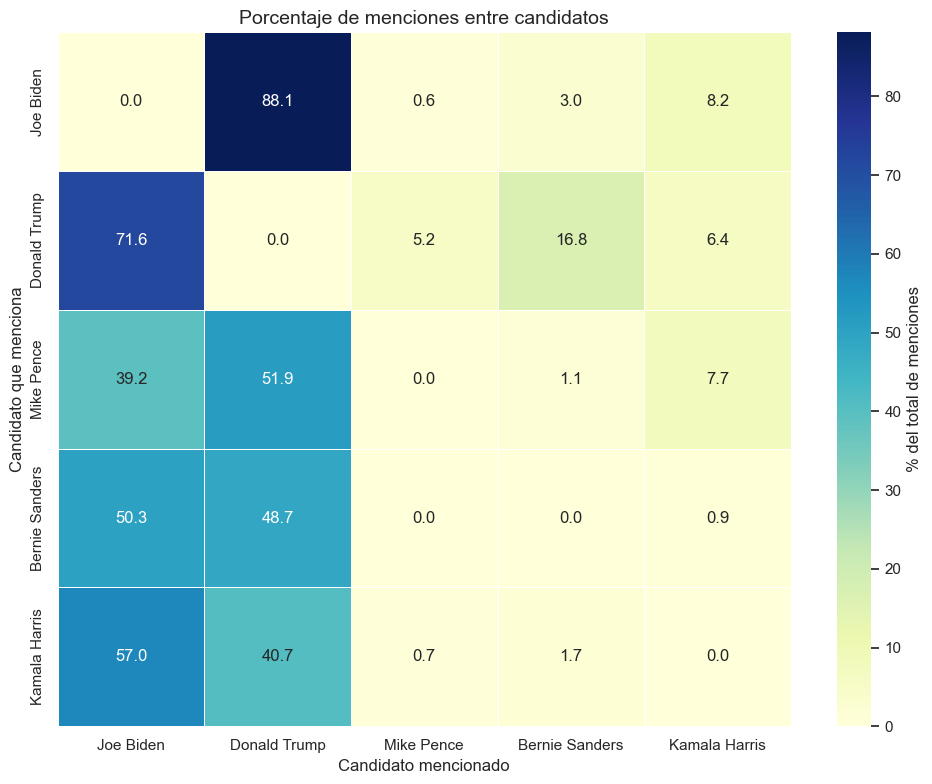


Total de menciones hechas por cada candidato:
Donald Trump      2073
Mike Pence        2039
Joe Biden          928
Bernie Sanders     318
Kamala Harris      302
dtype: int64

Total de menciones recibidas por cada candidato:
Joe Biden         2617
Donald Trump      2155
Bernie Sanders     403
Kamala Harris      369
Mike Pence         116
dtype: int64


In [63]:
# Parte C: Matriz de menciones entre candidatos

# Paso 1: Definir las variantes de nombres para cada candidato
# Estas son las diferentes formas en que un candidato puede ser mencionado
candidate_name_variants = {
    "Joe Biden": ["biden", "joe biden", "vice president biden", "vp biden", "former vice president"],
    "Donald Trump": ["trump", "donald trump", "president trump", "donald j trump"],
    "Mike Pence": ["pence", "mike pence", "vice president pence", "vp pence"],
    "Bernie Sanders": ["sanders", "bernie sanders", "bernie", "senator sanders"],
    "Kamala Harris": ["harris", "kamala harris", "kamala", "senator harris"]
}

# Paso 2: Crear una función que cuente menciones
def count_mentions(speaker_text, target_variants):
    """
    Cuenta cuántas veces aparecen las variantes del nombre de un candidato en un texto

    Parámetros:
    -----------
    speaker_text : str
        Texto limpio del discurso
    target_variants : list
        Lista de variantes del nombre del candidato objetivo

    Retorna:
    --------
    int : Número total de menciones
    """
    # Convertir a minúsculas para comparación insensible a mayúsculas/minúsculas
    text_lower = speaker_text.lower()

    # Contar menciones de cada variante
    total_mentions = 0
    for variant in target_variants:
        # Usamos \b para asegurar que encontramos palabras completas, no partes de palabras
        pattern = r'\b' + re.escape(variant) + r'\b'
        mentions = len(re.findall(pattern, text_lower))
        total_mentions += mentions

    return total_mentions

# Paso 3: Construir la matriz de menciones
# Inicializar matriz con ceros
mention_matrix = pd.DataFrame(0,
                             index=top5,
                             columns=top5)

# Paso 4: Recorrer todas las combinaciones de candidatos
print("Calculando menciones entre candidatos...")
for speaker in top5:
    # Obtener todos los discursos de este candidato
    speaker_speeches = df_speeches_top5[df_speeches_top5["speaker"] == speaker]["CleanText"]

    # Combinar todos los discursos en un solo texto para análisis
    combined_text = " ".join(speaker_speeches)

    # Contar menciones de cada candidato objetivo
    for target in top5:
        if speaker != target:  # Excluir auto-menciones
            target_variants = candidate_name_variants[target]
            mentions = count_mentions(combined_text, target_variants)
            mention_matrix.loc[speaker, target] = mentions

# Paso 5: Visualizar la matriz con un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    mention_matrix,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Número de menciones"}
)
plt.title("Matriz de menciones entre candidatos", fontsize=14)
plt.xlabel("Candidato mencionado")
plt.ylabel("Candidato que menciona")
plt.tight_layout()
plt.show()

# Paso 6: Crear una versión normalizada (porcentaje del total de menciones)
# Esto nos da una idea de la concentración relativa de menciones
# Crear una copia explícita y convertir a float antes de calcular porcentajes
mention_pct = mention_matrix.astype(float).copy()

for i in range(len(top5)):
    row_sum = mention_matrix.iloc[i, :].sum()
    if row_sum > 0:  # Evitar división por cero
        mention_pct.iloc[i, :] = mention_matrix.iloc[i, :] / row_sum * 100

# Visualizar matriz normalizada
plt.figure(figsize=(10, 8))
sns.heatmap(
    mention_pct,
    annot=True,
    fmt=".1f",  # Mostrar un decimal
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "% del total de menciones"}
)
plt.title("Porcentaje de menciones entre candidatos", fontsize=14)
plt.xlabel("Candidato mencionado")
plt.ylabel("Candidato que menciona")
plt.tight_layout()
plt.show()

# Paso 7: Análisis y comentarios
# Total de menciones hechas por cada candidato
total_mentions_made = mention_matrix.sum(axis=1).sort_values(ascending=False)
print("\nTotal de menciones hechas por cada candidato:")
print(total_mentions_made)

# Total de menciones recibidas por cada candidato
total_mentions_received = mention_matrix.sum(axis=0).sort_values(ascending=False)
print("\nTotal de menciones recibidas por cada candidato:")
print(total_mentions_received)

#### Explicación de la matriz de menciones

En el discurso político, los candidatos raramente son mencionados con un único nombre. Por ejemplo, Joe Biden puede ser referido como "Biden", "Joe Biden", "Vice President Biden" o "Former Vice President". Para capturar esta diversidad, definimos múltiples variantes para cada candidato:

candidate_name_variants = {
    "Joe Biden": ["biden", "joe biden", "vice president biden", "vp biden", "former vice president"],
    "Donald Trump": ["trump", "donald trump", "president trump", "donald j trump"],
    # ...otros candidatos
}

Esto nos permite detectar menciones independientemente de cómo un candidato sea referido, aumentando considerablemente la precisión del análisis.

Para asegurar que solo contamos palabras completas (y no partes de otras palabras), implementamos una función que utiliza expresiones regulares con delimitadores de palabras:

```def count_mentions(speaker_text, target_variants):
    text_lower = speaker_text.lower()
    total_mentions = 0
    for variant in target_variants:
        pattern = r'\b' + re.escape(variant) + r'\b'
        mentions = len(re.findall(pattern, text_lower))
        total_mentions += mentions
    return total_mentions
```

Los delimitadores \b son importantes porque aseguran que solo contemos palabras completas. Por ejemplo, con este enfoque, "trumpeting" no se contará como una mención de "trump".

#### Visualización de la matriz de menciones con grafos

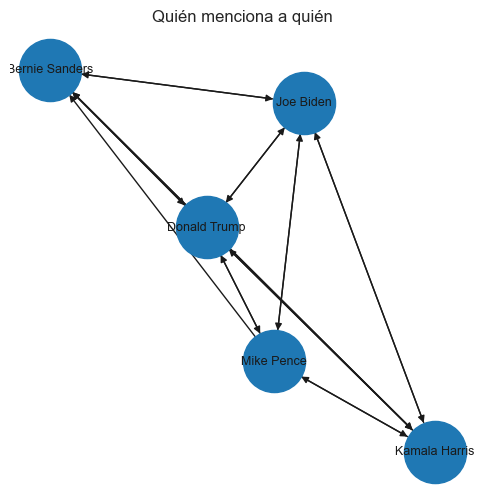

In [66]:
G = nx.from_pandas_adjacency(mention_matrix, create_using=nx.DiGraph)
pos = nx.spring_layout(G, seed=1)
plt.figure(figsize=(6,6))
nx.draw_networkx(G, pos, arrows=True, with_labels=True,
                 node_size=2000, font_size=9)
plt.title("Quién menciona a quién")
plt.axis("off")
plt.show()

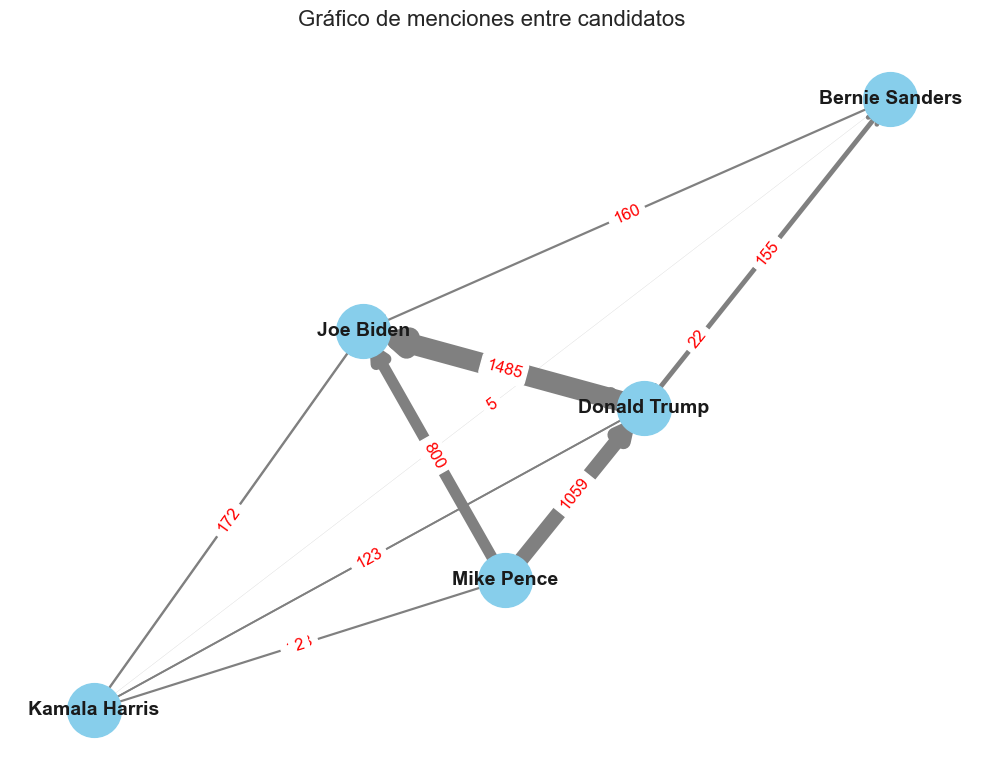

In [67]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Convertirla a array de NumPy para mantener la estructura del código original
np_mention_matrix = mention_matrix.values

# Los nombres de los candidatos (ya los tenemos en top5)
nodes = top5

# Crear un grafo dirigido
G = nx.DiGraph()

# Añadir aristas con pesos desde la matriz
for i, source in enumerate(nodes):
    for j, target in enumerate(nodes):
        weight = np_mention_matrix[i][j]
        if weight > 0:
            G.add_edge(source, target, weight=weight)

# Generar posiciones para los nodos
pos = nx.spring_layout(G, seed=42)  # Posición inicial

# Ajustar ligeramente las posiciones para mejor visualización
adjustment = 0.05  # Pequeño valor para ajustar las posiciones

# Modificar posiciones añadiendo un pequeño desplazamiento aleatorio
for node in pos:
    # Ajustar la posición x e y de cada nodo por una pequeña cantidad aleatoria
    pos[node] = (pos[node][0] + np.random.uniform(-adjustment, adjustment),
                 pos[node][1] + np.random.uniform(-adjustment, adjustment))

# Dibujar el grafo con posiciones ajustadas
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1500)
nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold')

# Escalar grosor de las aristas según el peso
edge_weights = [G[u][v]['weight']/100 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20,
                      edge_color='gray', width=edge_weights)

# Dibujar etiquetas de aristas (pesos)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                            font_color='red', font_size=12)

# Ajustes finales del gráfico
plt.title("Gráfico de menciones entre candidatos", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

#### Problemas con la visualización

Al ser un grafo bidireccional, en el gráfico resultante puede ser difícil de ver cada mención entre cada candidato. Una solución es hacer 5 grafos distintos, uno para cada candidato:

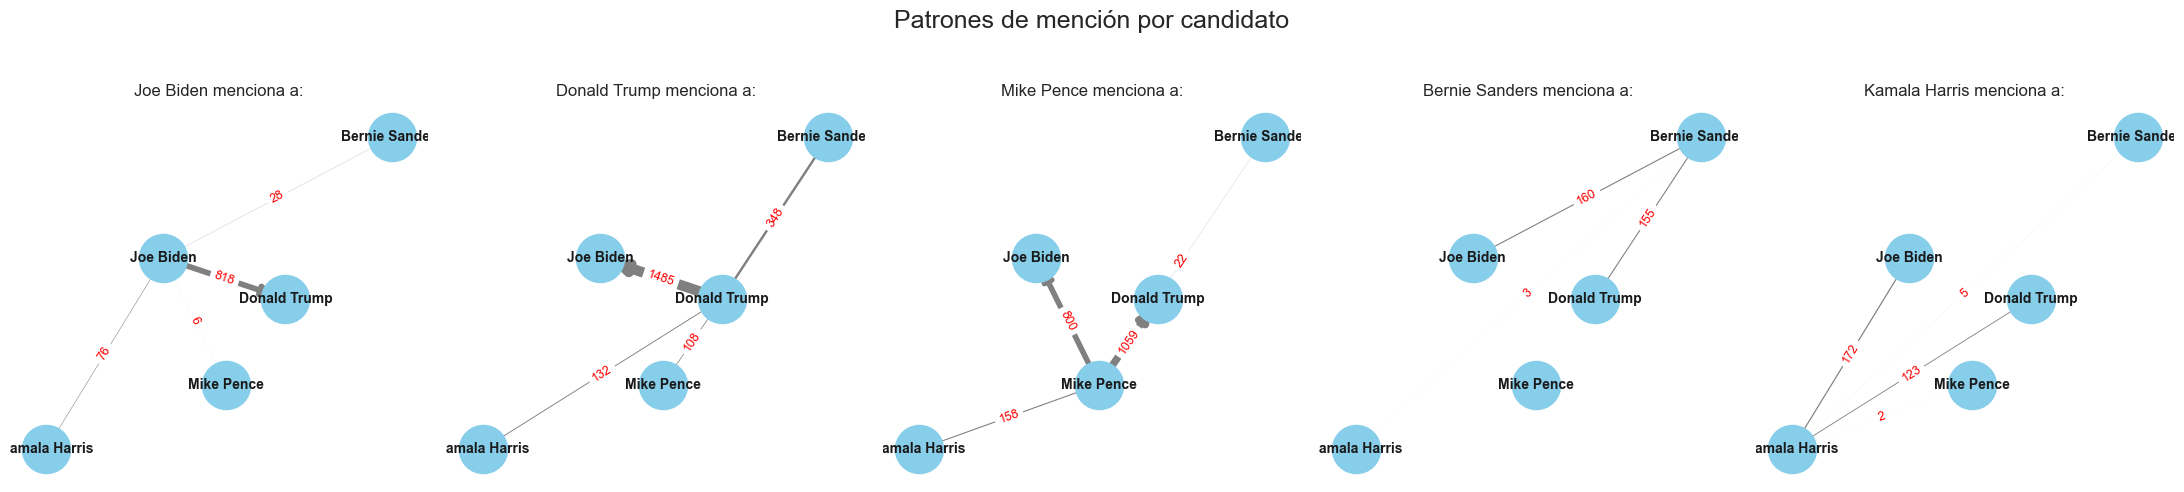

In [68]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Usar nuestra matriz de menciones existente
np_mention_matrix = mention_matrix.values
nodes = top5  # Usar nuestra lista de candidatos

# Generar un layout consistente para todos los grafos
full_graph = nx.DiGraph()
for i in range(len(nodes)):
    for j in range(len(nodes)):
        if np_mention_matrix[i, j] > 0:
            full_graph.add_edge(nodes[i], nodes[j], weight=np_mention_matrix[i, j])
pos = nx.spring_layout(full_graph, seed=42)  # Layout consistente

# Crear subplots
fig, axes = plt.subplots(1, 5, figsize=(22, 5))
fig.suptitle("Patrones de mención por candidato", fontsize=18)

# Dibujar un grafo por candidato
for idx, ax in enumerate(axes):
    speaker = nodes[idx]
    G = nx.DiGraph()

    # Añadir todos los nodos para mantener el layout consistente
    G.add_nodes_from(nodes)

    # Añadir solo las aristas de este candidato
    for j, target in enumerate(nodes):
        weight = np_mention_matrix[idx][j]
        if weight > 0:
            G.add_edge(speaker, nodes[j], weight=weight)

    # Dibujar el grafo
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='skyblue',
                          node_size=1200)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=10,
                           font_weight='bold')

    # Dibujar solo las aristas del candidato actual
    edges = G.edges(data=True)

    # Escalar el grosor de las aristas según el peso
    edge_weights = [d['weight']/200 for _, _, d in edges]

    nx.draw_networkx_edges(G, pos, edgelist=edges, ax=ax,
                          arrowstyle='-|>', arrowsize=15,
                          edge_color='gray', width=edge_weights)

    # Dibujar etiquetas de aristas
    edge_labels = {(u, v): d['weight'] for u, v, d in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                                ax=ax, font_size=9, font_color='red')

    ax.set_title(f"{speaker} menciona a:", fontsize=12)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Parte D: Tres preguntas adicionales

**1. ¿Cómo evolucionó el lenguaje y los temas de los candidatos a lo largo de la campaña?**

Los discursos políticos suelen adaptarse a eventos externos, resultados de encuestas y estrategias cambiantes. Analizar la evolución temporal del lenguaje nos permitiría entender cómo los candidatos ajustan sus mensajes.

Enfoque metodológico:

Dividir los discursos en intervalos temporales significativos (mensual, por etapas de campaña)
Para cada intervalo, extraer los temas principales usando técnicas como modelado de tópicos (LDA)
Analizar cambios en la frecuencia de palabras clave específicas a lo largo del tiempo
Comparar cómo cambia el tono emocional de los discursos mediante análisis de sentimiento
Este análisis revelaría, por ejemplo, si Trump cambió su retórica después de eventos clave o si Biden modificó sus temas prioritarios en diferentes estados.

**2. ¿Qué diferencias existen en el discurso de los candidatos según la ubicación geográfica?**

Los candidatos adaptan sus mensajes según las preocupaciones locales y la composición demográfica de cada región. Esta pregunta nos permitiría comprender cómo personalizan su comunicación.

Enfoque metodológico:

Agrupar discursos por estado o región (noreste, sur, medio oeste, etc.)
Identificar términos distintivos para cada región mediante análisis de frecuencia comparativa
Analizar si hay temas específicos que solo se abordan en ciertas regiones
Examinar las menciones de industrias o sectores económicos relevantes para cada estado
Este análisis podría mostrar, por ejemplo, que en estados con alta producción agrícola se habla más de subsidios y aranceles, mientras que en zonas urbanas se enfatiza vivienda o transporte.

**3. ¿Qué estrategias retóricas caracterizan a cada candidato y cómo se relacionan con su éxito electoral?**

Más allá de los temas abordados, la forma en que los candidatos comunican sus ideas puede ser tan importante como el contenido mismo. Esta pregunta explora patrones lingüísticos distintivos.

Enfoque metodológico:

Analizar la complejidad lingüística (longitud de oraciones, diversidad de vocabulario)
Identificar patrones de uso de la primera persona (yo, nosotros) versus tercera persona.
Examinar el uso de lenguaje emocional o cargado versus lenguaje neutro.
Estudiar la frecuencia de ciertos recursos retóricos: preguntas, llamados a la acción, anécdotas
Correlacionar estos patrones con la respuesta del público (encuestas posteriores a discursos)
Este análisis podría revelar, por ejemplo, que algunos candidatos utilizan lenguaje más sencillo y directo, mientras que otros emplean un vocabulario más sofisticado, y cómo estas diferencias impactan en su capacidad para conectar con distintos segmentos del electorado.